In [7]:
import numpy as np

def read_xcat_bin_image(file_path: str,
                        width: int = 128,
                        height: int = 128,
                        depth: int = 128) -> np.array:
    

    # Define the dimensions of the image


    # Calculate the number of elements in the image
    num_elements = width * height * depth
    
    # Read the binary file
    image_data = np.fromfile(file_path, dtype=np.float32, count=num_elements)
    
    # Reshape the data to the desired dimensions (depth, height, width)
    image_data = image_data.reshape((depth, height, width))
    image_data = np.rot90(image_data, 2)
    return image_data

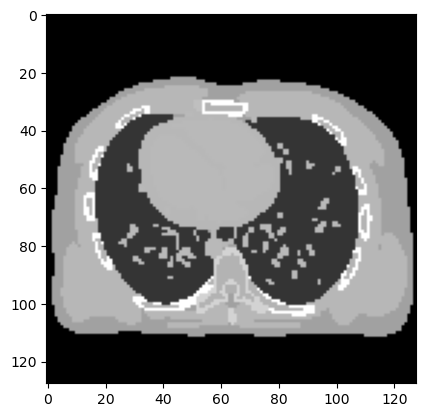

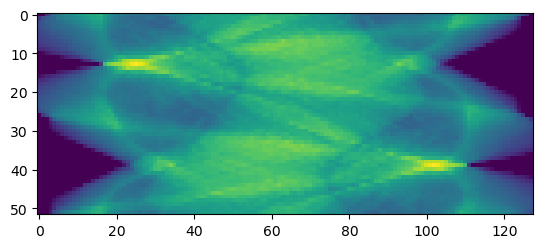

In [8]:
from src.operators.radon import Radon
from src.operators.total_variation import TotalVariation
from src.solvers.pwls import PWLS
from src.solvers.chambolle_pock import ChambollePock
from src.solvers.admm import ADMM


from PIL import Image
import torch
import numpy as np
import torch_radon as tr
import matplotlib.pyplot as plt

device = 'cuda'

# define projector settings
n_rays = 128
height, width = 128, 128
n_angles = 52
volume = tr.Volume2D()
volume.set_size(height=height, width=width)
angles = torch.linspace(0, 2 * torch.pi * ((n_angles - 1))/n_angles, n_angles, device=device)

# define projector
radon = Radon(n_rays=n_rays,
              angles=angles,
              volume=volume)  # Radon class

# load image
img_path = './data/t1_atn_1.bin'
x_true = read_xcat_bin_image(img_path)[64, :, :] # produces a squeezed image
x_true = np.rot90( x_true , 2 )
plt.imshow(x_true,cmap='gray')
plt.show() # to avoid overprinting images

# The following is needed to create a Torch object. This requires to add 2 additional dimensions, 1 for batch size, 1 for the number of channels (n,c,d,h,w) (d for depth (not used here in 2D))
x_true = torch.from_numpy(  x_true.copy()   ).unsqueeze(0).unsqueeze(0).to(device)   # 0 is the index of the dimension to be added


# generate noisy sinogram
I = 3e5
EPS = 1e-10
sino = radon.transform(x_true)
yi = torch.poisson(I*torch.exp(-sino))
b = torch.zeros_like(yi)
# b = torch.log(I/ (yi))
b[yi != 0] = torch.log(I/ (yi[yi != 0])) ;


# print(yi.min())

# shared params
x0 = torch.zeros_like(x_true, device=device)

b_im = b.squeeze().cpu().numpy()
plt.imshow(b_im)
# to avoid overprinting images
plt.show() # to avoid overprinting images
n_iter = 300
n_inner_iter = 100
weights = yi
weights[yi == 0] = 0

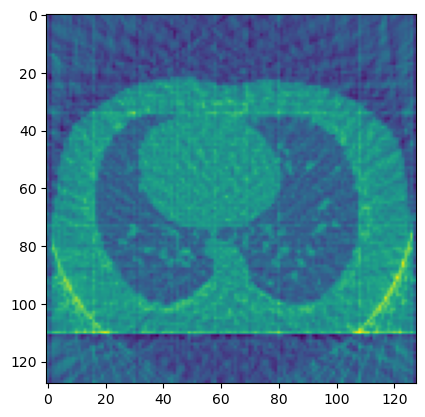

In [11]:
#############################################################################################################################
#                                                           FBP                                                             #
#############################################################################################################################


x_fbp = radon.fbp(b)
plt.show() # to avoid overprinting images
plt.imshow(x_fbp.cpu().squeeze())

plt.imsave('./data/fbp.png', x_fbp.cpu().squeeze(), cmap='gray')

In [ ]:
#############################################################################################################################
#                                                           PWLS                                                            #
#############################################################################################################################

# tv = TotalVariation(penalty='l2')
# solver = PWLS(radon=radon, regularizer=tv)

# beta = 1e5

# x = solver.solve(x0,
#                 b,
#                 beta,
#                 n_iter,
#                 weights)

In [ ]:
#############################################################################################################################
#                                                           ADMM                                                            #
#############################################################################################################################

# tv = TotalVariation(penalty='l1')
# solver = ADMM(radon=radon, regularizer=tv)

# beta = 3e2
# rho = 5000

# x = solver.solve(x0,
#                 b,
#                 beta,
#                 rho,
#                 n_iter,
#                 n_inner_iter,
#                 weights)

In [ ]:
#############################################################################################################################
#                                                      Chambolle Pock                                                       #
#############################################################################################################################




# tv = TotalVariation(penalty='l1')
# solver = ChambollePock(radon=radon, regularizer=tv)

# beta = 3e2
# theta = 1
# L = tv.norm(height, width)
# sigma = 0.99 * (1e8 / (np.sqrt(1e8 * 1) * L))
# tau = 0.99 * (1 / (np.sqrt(1e8 * 1) * L))

# x = solver.solve( x0,
#                     b,
#                     beta,
#                     tau,
#                     sigma,
#                     theta,
#                     n_iter,
#                     n_inner_iter,
#                     weights)